<a href="https://colab.research.google.com/github/ChoHyeonJun86/First-Project/blob/main/deeplearning_%EB%88%88_%EA%B0%90%EC%A7%80_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B_%EB%A1%9C%EB%93%9C_%EB%B0%8F_%EC%A0%84%EC%B2%98%EB%A6%AC_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python dlib imutils numpy matplotlib

In [17]:
from google.colab import files
files.upload()  # kaggle.json 파일 업로드

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"greenmush","key":"83b1f89d531313cf14c997bd8c4ab6ac"}'}

In [18]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install -q kaggle

In [5]:
# Drowsiness Detection Dataset (prasadvpatil) 다운로드
!kaggle datasets download -d prasadvpatil/mrl-dataset

# 다운로드된 파일 압축 해제
!unzip mrl-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/prasadvpatil/mrl-dataset
License(s): CC0-1.0
  0% 0.00/22.6M [00:00<?, ?B/s]
100% 22.6M/22.6M [00:00<00:00, 411MB/s]
Archive:  mrl-dataset.zip
  inflating: train/Closed_Eyes/s0001_00001_0_0_0_0_0_01.png  
  inflating: train/Closed_Eyes/s0001_00002_0_0_0_0_0_01.png  
  inflating: train/Closed_Eyes/s0001_00003_0_0_0_0_0_01.png  
  inflating: train/Closed_Eyes/s0001_00004_0_0_0_0_0_01.png  
  inflating: train/Closed_Eyes/s0001_00005_0_0_0_0_0_01.png  
  inflating: train/Closed_Eyes/s0001_00006_0_0_0_0_0_01.png  
  inflating: train/Closed_Eyes/s0001_00007_0_0_0_0_0_01.png  
  inflating: train/Closed_Eyes/s0001_00008_0_0_0_0_0_01.png  
  inflating: train/Closed_Eyes/s0001_00009_0_0_0_0_0_01.png  
  inflating: train/Closed_Eyes/s0001_00011_0_0_0_0_0_01.png  
  inflating: train/Closed_Eyes/s0001_00013_0_0_0_0_0_01.png  
  inflating: train/Closed_Eyes/s0001_00014_0_0_0_0_0_01.png  
  inflating: train/Closed_Eyes/s0001_00015_0_0_0_0_0_01.png  
  infl

훈련 데이터셋 로드 중...
Found 3200 images belonging to 2 classes.

검증 데이터셋 로드 중...
Found 800 images belonging to 2 classes.

테스트 데이터셋 로드 중...
경고: '/content/test' 디렉토리가 없습니다. 테스트 데이터셋을 로드할 수 없습니다.

--- 데이터셋 로드 정보 ---
훈련 데이터: 3200개 이미지, 2개 클래스
검증 데이터: 800개 이미지, 2개 클래스
테스트 데이터: 로드되지 않음 (디렉토리 없음)

클래스 인덱스:
{'Closed_Eyes': 0, 'Open_Eyes': 1}


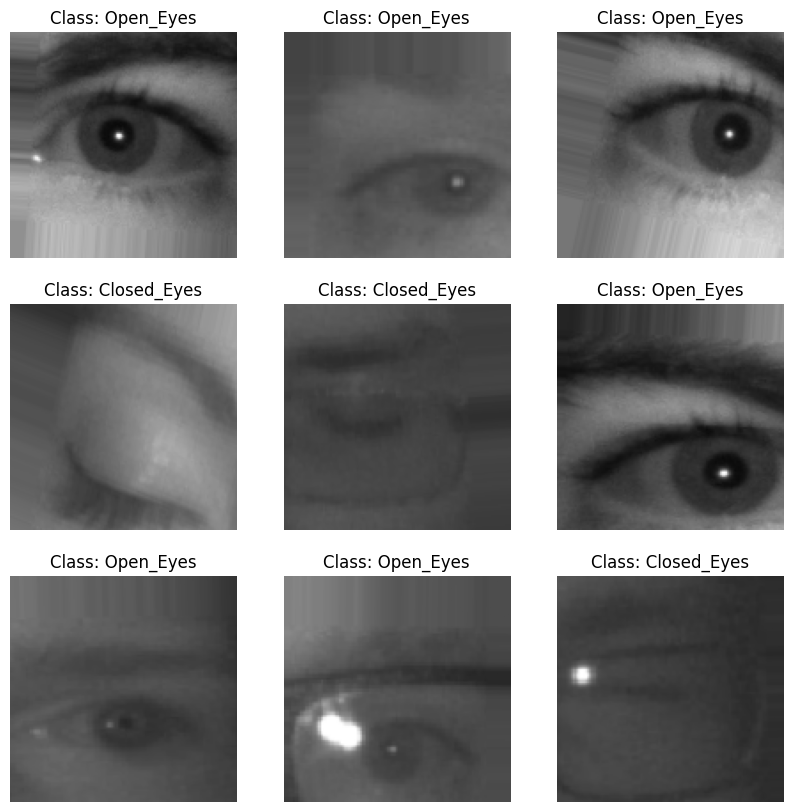

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋의 기본 경로 설정
# 'train' 폴더가 /content/ 바로 아래에 있으므로 base_dir을 /content/로 설정합니다.
base_dir = '/content' # 경로를 수정했습니다.
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
# valid_dir = os.path.join(base_dir, 'valid') # 'valid' 디렉토리가 있을 수 있으나,
                                          # 훈련 데이터에서 분리하는 방식을 유지합니다.

# 이미지 전처리 및 데이터 증강을 위한 ImageDataGenerator 설정
# rescale=1./255: 픽셀 값을 0-255에서 0-1 사이로 정규화하여 모델 학습 효율을 높입니다.
# validation_split=0.2: 훈련 데이터의 20%를 검증 데이터로 분리하여 사용합니다.
# 이는 별도의 'valid' 폴더가 없거나, 데이터셋에 검증 폴더가 없는 경우 유용합니다.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,        # 이미지를 20도까지 무작위 회전
    width_shift_range=0.2,    # 이미지를 가로로 0.2 (전체 너비의 20%)까지 무작위 이동
    height_shift_range=0.2,   # 이미지를 세로로 0.2 (전체 높이의 20%)까지 무작위 이동
    shear_range=0.2,          # 층밀림 변환(shear transformation) 적용
    zoom_range=0.2,           # 이미지를 0.2 (20%)까지 무작위 확대/축소
    horizontal_flip=True,     # 이미지를 무작위로 좌우 반전
    fill_mode='nearest',      # 변환 시 새로 생성되는 픽셀을 가장 가까운 픽셀로 채움
    validation_split=0.2      # 훈련 데이터의 20%를 검증 데이터로 분리
)

# 테스트 데이터는 모델 성능 평가에 사용되므로, 데이터 증강 없이 정규화만 수행합니다.
test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지 로드 및 데이터 증강 적용을 위한 flow_from_directory 설정
# target_size: 모든 이미지를 이 크기로 조정합니다. (예: 128x128 픽셀)
# batch_size: 한 번에 모델에 전달할 이미지의 수입니다.
# class_mode: 'binary'는 이진 분류(두 개의 클래스, 여기서는 Open_Eyes/Closed_Eyes)에 사용됩니다.
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 32

print("훈련 데이터셋 로드 중...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training', # 훈련 세트 지정
    seed=42, # 재현성을 위해 시드 설정
    shuffle=True # 훈련 데이터는 모델이 다양한 패턴을 학습하도록 섞어서 사용합니다.
)

print("\n검증 데이터셋 로드 중...")
validation_generator = train_datagen.flow_from_directory(
    train_dir, # 훈련 디렉토리에서 검증 데이터 분리
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation', # 검증 세트 지정
    seed=42, # 재현성을 위해 시드 설정
    shuffle=False # 검증 데이터는 성능 평가를 위해 순서를 유지합니다.
)

print("\n테스트 데이터셋 로드 중...")
# 테스트 디렉토리가 존재하는지 확인
if os.path.exists(test_dir):
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False # 테스트 데이터도 성능 평가를 위해 순서를 유지합니다.
    )
    print(f"'{test_dir}'에서 테스트 데이터셋을 로드했습니다.")
else:
    print(f"경고: '{test_dir}' 디렉토리가 없습니다. 테스트 데이터셋을 로드할 수 없습니다.")
    test_generator = None # 테스트 데이터셋 로드 실패를 표시

# 데이터셋 로드 결과 확인
print("\n--- 데이터셋 로드 정보 ---")
print(f"훈련 데이터: {train_generator.samples}개 이미지, {train_generator.num_classes}개 클래스")
print(f"검증 데이터: {validation_generator.samples}개 이미지, {validation_generator.num_classes}개 클래스")
# test_generator가 None이 아닐 경우에만 정보 출력
if test_generator:
    print(f"테스트 데이터: {test_generator.samples}개 이미지, {test_generator.num_classes}개 클래스")
else:
    print("테스트 데이터: 로드되지 않음 (디렉토리 없음)")


# 클래스 인덱스 확인 (어떤 숫자가 어떤 클래스를 나타내는지)
# 예를 들어, {'Closed_Eyes': 0, 'Open_Eyes': 1} 와 같이 출력될 수 있습니다.
print("\n클래스 인덱스:")
print(train_generator.class_indices)

# 첫 번째 배치 이미지 시각화

x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(min(9, BATCH_SIZE)): # 최대 9개 이미지 시각화 (또는 배치 크기 내에서)
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    # 클래스 인덱스를 실제 클래스 이름으로 변환하여 제목에 표시
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    plt.title(f"Class: {class_labels[y_batch[i]]}")
    plt.axis('off')
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)


모델 학습 시작...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.6070 - loss: 0.7181
Epoch 1: val_accuracy improved from -inf to 0.65125, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.6079 - loss: 0.7165 - val_accuracy: 0.6513 - val_loss: 0.6322
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8574 - loss: 0.3287
Epoch 2: val_accuracy did not improve from 0.65125
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.8575 - loss: 0.3285 - val_accuracy: 0.6450 - val_loss: 0.6255
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8838 - loss: 0.2825
Epoch 3: val_accuracy improved from 0.65125 to 0.69750, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - accuracy: 0.8839 - loss: 0.2822 - val_accuracy: 0.6975 - val_loss: 0.5774
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9042 - loss: 0.2335
Epoch 4: val_accuracy did not improve from 0.69750
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - accuracy: 0.9042 - loss: 0.2334 - val_accuracy: 0.6963 - val_loss: 0.5695
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9148 - loss: 0.2163
Epoch 5: val_accuracy improved from 0.69750 to 0.69875, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - accuracy: 0.9148 - loss: 0.2163 - val_accuracy: 0.6988 - val_loss: 0.5457
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9257 - loss: 0.1883
Epoch 6: val_accuracy improved from 0.69875 to 0.76375, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.9257 - loss: 0.1884 - val_accuracy: 0.7638 - val_loss: 0.5487
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9334 - loss: 0.1793
Epoch 7: val_accuracy improved from 0.76375 to 0.81750, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.9334 - loss: 0.1792 - val_accuracy: 0.8175 - val_loss: 0.4192
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9420 - loss: 0.1559
Epoch 8: val_accuracy did not improve from 0.81750
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.9419 - loss: 0.1561 - val_accuracy: 0.7763 - val_loss: 0.5209
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9405 - loss: 0.1475
Epoch 9: val_accuracy improved from 0.81750 to 0.86125, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 201ms/step - accuracy: 0.9406 - loss: 0.1476 - val_accuracy: 0.8612 - val_loss: 0.3577
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9504 - loss: 0.1389
Epoch 10: val_accuracy did not improve from 0.86125
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.9504 - loss: 0.1389 - val_accuracy: 0.8562 - val_loss: 0.3995
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9557 - loss: 0.1238
Epoch 11: val_accuracy did not improve from 0.86125
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 182ms/step - accuracy: 0.9557 - loss: 0.1239 - val_accuracy: 0.7250 - val_loss: 0.7507
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9349 - loss: 0.1662
Epoch 12: val_accuracy did not improve from 0.86125
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - accuracy: 0.9349 - loss: 0.1662 - val_accuracy: 0.6837 - val_loss: 0.6999
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9279 - loss: 0.1883
Epoch 13

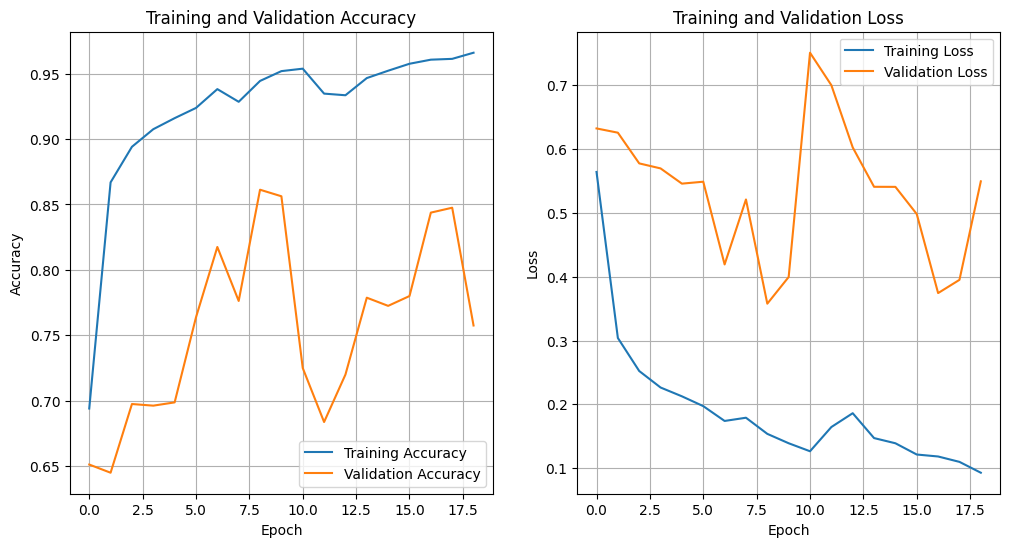


학습 결과 시각화 완료.


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

# 이전에 정의된 IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE는 이전 코드 셀에서 사용되었으므로,
# 현재 셀에서 사용하려면 다시 정의하거나, 이전 셀이 실행되어 변수들이 전역적으로 사용 가능해야 합니다.
# 안전을 위해 여기서 다시 정의합니다.
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 32

# --- 1. 모델 구축 ---
# 간단한 CNN 모델 정의
def create_cnn_model(input_shape):
    model = models.Sequential([
        # 첫 번째 합성곱 블록
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25), # 과적합 방지를 위한 Dropout 추가

        # 두 번째 합성곱 블록
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # 세 번째 합성곱 블록
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # 특징 맵을 1차원 벡터로 평탄화 (완전 연결 층에 입력하기 위함)
        layers.Flatten(),

        # 완전 연결 층
        layers.Dense(256, activation='relu'), # 뉴런 256개
        layers.Dropout(0.5), # 과적합 방지를 위한 Dropout 추가

        # 출력 층
        # 이진 분류 (눈 감김/떠짐)이므로 sigmoid 활성화 함수를 사용합니다.
        # 출력 뉴런은 1개입니다.
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# 모델 생성
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3) # 컬러 이미지이므로 채널이 3
model = create_cnn_model(input_shape)

# 모델 요약 출력 (층별 구조와 파라미터 수 확인)
model.summary()

# 모델 컴파일
# optimizer: Adam은 일반적으로 좋은 성능을 보이는 최적화 알고리즘입니다.
# loss: 이진 분류이므로 binary_crossentropy를 사용합니다.
# metrics: 학습 및 평가 시 모니터링할 지표 (여기서는 정확도)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- 2. 모델 학습 ---
# 콜백 함수 설정 (모델 학습을 효율적으로 제어)
# EarlyStopping: 검증 손실이 개선되지 않으면 학습을 조기 종료하여 과적합 방지
# patience: 몇 epoch 동안 개선이 없으면 조기 종료할지 지정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ModelCheckpoint: 검증 정확도가 가장 높은 모델을 저장
# save_best_only=True: 가장 좋은 성능을 보이는 모델만 저장
model_checkpoint = ModelCheckpoint(
    'best_drowsiness_model.h5', # 저장될 모델 파일 이름
    monitor='val_accuracy',
    mode='max', # val_accuracy는 높을수록 좋으므로 'max'
    save_best_only=True,
    verbose=1 # 저장 시 메시지 출력
)

# 모델 학습
# epochs: 전체 훈련 데이터를 몇 번 반복하여 학습할지
# validation_data: 학습 중 모델 성능을 검증할 데이터셋
# callbacks: 위에 정의한 콜백 함수들
print("\n모델 학습 시작...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, # 한 epoch당 steps 수
    epochs=50, # 충분히 많은 epoch를 설정하고 EarlyStopping으로 조기 종료 유도
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE, # 한 epoch당 검증 steps 수
    callbacks=[early_stopping, model_checkpoint]
)

print("\n모델 학습 완료.")

# --- 3. 학습 결과 시각화 ---
# 학습 과정의 정확도와 손실 그래프
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.show()

print("\n학습 결과 시각화 완료.")


훈련 데이터셋 로드 중...
Found 3200 images belonging to 2 classes.

검증 데이터셋 로드 중...
Found 800 images belonging to 2 classes.

테스트 데이터셋 로드 중...
경고: '/content/test' 디렉토리가 없습니다. 테스트 데이터셋을 로드할 수 없습니다.

--- 데이터셋 로드 정보 ---
훈련 데이터: 3200개 이미지, 2개 클래스
검증 데이터: 800개 이미지, 2개 클래스
테스트 데이터: 로드되지 않음 (디렉토리 없음)

클래스 인덱스:
{'Closed_Eyes': 0, 'Open_Eyes': 1}


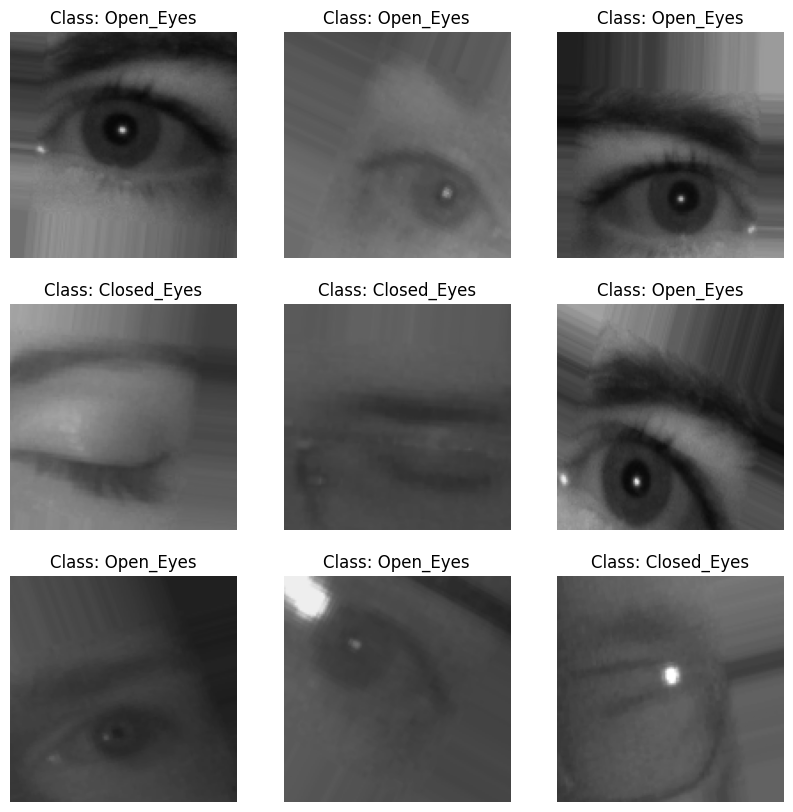

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋의 기본 경로 설정
# 'train' 폴더가 /content/ 바로 아래에 있으므로 base_dir을 /content/로 설정합니다.
base_dir = '/content' # 경로를 수정했습니다.
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
# valid_dir = os.path.join(base_dir, 'valid') # 'valid' 디렉토리가 있을 수 있으나,
                                          # 훈련 데이터에서 분리하는 방식을 유지합니다.

# 이미지 전처리 및 데이터 증강을 위한 ImageDataGenerator 설정
# rescale=1./255: 픽셀 값을 0-255에서 0-1 사이로 정규화하여 모델 학습 효율을 높입니다.
# validation_split=0.2: 훈련 데이터의 20%를 검증 데이터로 분리하여 사용합니다.
# 이는 별도의 'valid' 폴더가 없거나, 데이터셋에 검증 폴더가 없는 경우 유용합니다.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,        # 이미지를 30도까지 무작위 회전 (기존 20도에서 증가)
    width_shift_range=0.25,   # 이미지를 가로로 0.25 (전체 너비의 25%)까지 무작위 이동 (기존 0.2에서 증가)
    height_shift_range=0.25,  # 이미지를 세로로 0.25 (전체 높이의 25%)까지 무작위 이동 (기존 0.2에서 증가)
    shear_range=0.25,         # 층밀림 변환(shear transformation) 적용 (기존 0.2에서 증가)
    zoom_range=0.25,          # 이미지를 0.25 (25%)까지 무작위 확대/축소 (기존 0.2에서 증가)
    horizontal_flip=True,     # 이미지를 무작위로 좌우 반전
    brightness_range=[0.7, 1.3], # 밝기 변화 추가 (원본 밝기의 70%~130% 사이)
    channel_shift_range=0.1,  # 채널 값 무작위 변화 추가 (색상 변화 유도)
    fill_mode='nearest',      # 변환 시 새로 생성되는 픽셀을 가장 가까운 픽셀로 채움
    validation_split=0.2      # 훈련 데이터의 20%를 검증 데이터로 분리
)

# 테스트 데이터는 모델 성능 평가에 사용되므로, 데이터 증강 없이 정규화만 수행합니다.
test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지 로드 및 데이터 증강 적용을 위한 flow_from_directory 설정
# target_size: 모든 이미지를 이 크기로 조정합니다. (예: 128x128 픽셀)
# batch_size: 한 번에 모델에 전달할 이미지의 수입니다.
# class_mode: 'binary'는 이진 분류(두 개의 클래스, 여기서는 Open_Eyes/Closed_Eyes)에 사용됩니다.
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 32

print("훈련 데이터셋 로드 중...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training', # 훈련 세트 지정
    seed=42, # 재현성을 위해 시드 설정
    shuffle=True # 훈련 데이터는 모델이 다양한 패턴을 학습하도록 섞어서 사용합니다.
)

print("\n검증 데이터셋 로드 중...")
validation_generator = train_datagen.flow_from_directory(
    train_dir, # 훈련 디렉토리에서 검증 데이터 분리
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation', # 검증 세트 지정
    seed=42, # 재현성을 위해 시드 설정
    shuffle=False # 검증 데이터는 성능 평가를 위해 순서를 유지합니다.
)

print("\n테스트 데이터셋 로드 중...")
# 테스트 디렉토리가 존재하는지 확인
if os.path.exists(test_dir):
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False # 테스트 데이터도 성능 평가를 위해 순서를 유지합니다.
    )
    print(f"'{test_dir}'에서 테스트 데이터셋을 로드했습니다.")
else:
    print(f"경고: '{test_dir}' 디렉토리가 없습니다. 테스트 데이터셋을 로드할 수 없습니다.")
    test_generator = None # 테스트 데이터셋 로드 실패를 표시

# 데이터셋 로드 결과 확인
print("\n--- 데이터셋 로드 정보 ---")
print(f"훈련 데이터: {train_generator.samples}개 이미지, {train_generator.num_classes}개 클래스")
print(f"검증 데이터: {validation_generator.samples}개 이미지, {validation_generator.num_classes}개 클래스")
# test_generator가 None이 아닐 경우에만 정보 출력
if test_generator:
    print(f"테스트 데이터: {test_generator.samples}개 이미지, {test_generator.num_classes}개 클래스")
else:
    print("테스트 데이터: 로드되지 않음 (디렉토리 없음)")


# 클래스 인덱스 확인 (어떤 숫자가 어떤 클래스를 나타내는지)
# 예를 들어, {'Closed_Eyes': 0, 'Open_Eyes': 1} 와 같이 출력될 수 있습니다.
print("\n클래스 인덱스:")
print(train_generator.class_indices)

# 시각화
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(min(9, BATCH_SIZE)): # 최대 9개 이미지 시각화 (또는 배치 크기 내에서)
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
     # 클래스 인덱스를 실제 클래스 이름으로 변환하여 제목에 표시
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    plt.title(f"Class: {class_labels[y_batch[i]]}")
    plt.axis('off')
plt.show()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)


모델 학습 시작...
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5721 - loss: 0.7860
Epoch 1: val_accuracy improved from -inf to 0.56375, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 237ms/step - accuracy: 0.5730 - loss: 0.7842 - val_accuracy: 0.5638 - val_loss: 0.6803
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8002 - loss: 0.4129
Epoch 2: val_accuracy improved from 0.56375 to 0.77250, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.8003 - loss: 0.4126 - val_accuracy: 0.7725 - val_loss: 0.5780
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8255 - loss: 0.3632
Epoch 3: val_accuracy did not improve from 0.77250
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.8256 - loss: 0.3631 - val_accuracy: 0.7550 - val_loss: 0.5545
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8721 - loss: 0.3028
Epoch 4: val_accuracy improved from 0.77250 to 0.81875, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step - accuracy: 0.8722 - loss: 0.3027 - val_accuracy: 0.8188 - val_loss: 0.4488
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8637 - loss: 0.2930
Epoch 5: val_accuracy did not improve from 0.81875
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 228ms/step - accuracy: 0.8637 - loss: 0.2932 - val_accuracy: 0.7862 - val_loss: 0.5186
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8946 - loss: 0.2834
Epoch 6: val_accuracy did not improve from 0.81875
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.8946 - loss: 0.2834 - val_accuracy: 0.7962 - val_loss: 0.4698
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9029 - loss: 0.2380
Epoch 7: val_accuracy did not improve from 0.81875
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step - accuracy: 0.9028 - loss: 0.2381 - val_accuracy: 0.7862 - val_loss: 0.4940
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9166 - loss: 0.2213
Epoch 8: val_ac

100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.9166 - loss: 0.2213 - val_accuracy: 0.8413 - val_loss: 0.3851
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9348 - loss: 0.1763
Epoch 9: val_accuracy improved from 0.84125 to 0.90125, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 231ms/step - accuracy: 0.9348 - loss: 0.1763 - val_accuracy: 0.9013 - val_loss: 0.3025
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9523 - loss: 0.1422
Epoch 10: val_accuracy did not improve from 0.90125
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - accuracy: 0.9523 - loss: 0.1422 - val_accuracy: 0.7937 - val_loss: 0.4289
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9502 - loss: 0.1401
Epoch 11: val_accuracy improved from 0.90125 to 0.91125, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 231ms/step - accuracy: 0.9502 - loss: 0.1400 - val_accuracy: 0.9112 - val_loss: 0.2424
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9687 - loss: 0.1027
Epoch 12: val_accuracy did not improve from 0.91125
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.9687 - loss: 0.1027 - val_accuracy: 0.8675 - val_loss: 0.3500
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9676 - loss: 0.0953
Epoch 13: val_accuracy did not improve from 0.91125
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.9676 - loss: 0.0953 - val_accuracy: 0.8425 - val_loss: 0.3496
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9605 - loss: 0.0957
Epoch 14: val_accuracy did not improve from 0.91125
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.9605 - loss: 0.0958 - val_accuracy: 0.8525 - val_loss: 0.3427
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9662 - loss: 0.1064
Epoch 15

100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.9709 - loss: 0.0791 - val_accuracy: 0.9337 - val_loss: 0.1763
Epoch 19/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9808 - loss: 0.0658
Epoch 19: val_accuracy did not improve from 0.93375
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.9808 - loss: 0.0658 - val_accuracy: 0.9200 - val_loss: 0.2224
Epoch 20/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9742 - loss: 0.0781
Epoch 20: val_accuracy did not improve from 0.93375
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 228ms/step - accuracy: 0.9742 - loss: 0.0782 - val_accuracy: 0.8562 - val_loss: 0.3024
Epoch 21/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9830 - loss: 0.0511
Epoch 21: val_accuracy did not improve from 0.93375
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.9829 - loss: 0.0512 - val_accuracy: 0.8988 - val_loss: 0.2239
Epoch 22/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9843 - loss: 0.0591
Epoch 22

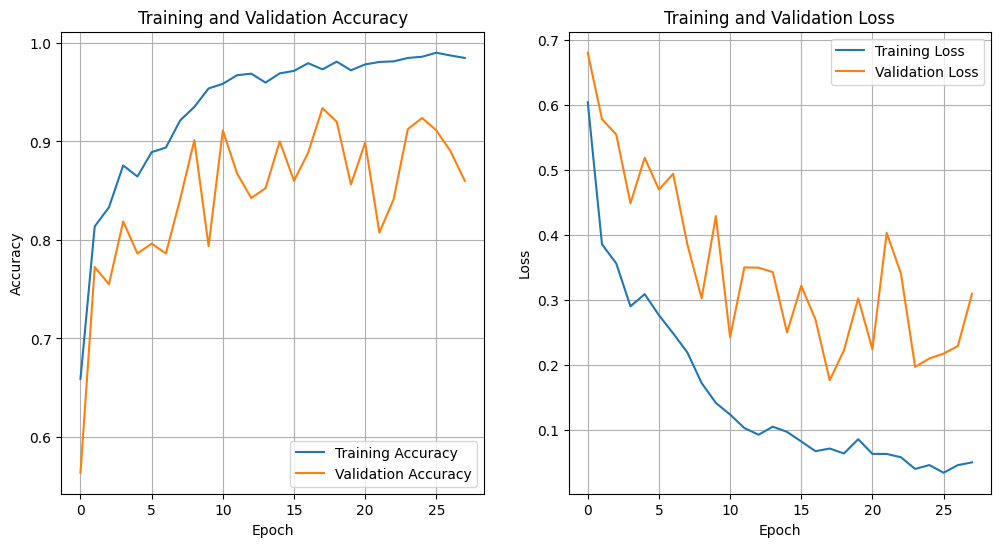


학습 결과 시각화 완료.


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

# 이전에 정의된 IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE는 이전 코드 셀에서 사용되었으므로,
# 현재 셀에서 사용하려면 다시 정의하거나, 이전 셀이 실행되어 변수들이 전역적으로 사용 가능해야 합니다.
# 안전을 위해 여기서 다시 정의합니다.
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 32

# --- 1. 모델 구축 ---
# 간단한 CNN 모델 정의
def create_cnn_model(input_shape):
    model = models.Sequential([
        # 첫 번째 합성곱 블록
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25), # 과적합 방지를 위한 Dropout 추가

        # 두 번째 합성곱 블록
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # 세 번째 합성곱 블록
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # 특징 맵을 1차원 벡터로 평탄화 (완전 연결 층에 입력하기 위함)
        layers.Flatten(),

        # 완전 연결 층
        layers.Dense(256, activation='relu'), # 뉴런 256개
        layers.Dropout(0.5), # 과적합 방지를 위한 Dropout 추가

        # 출력 층
        # 이진 분류 (눈 감김/떠짐)이므로 sigmoid 활성화 함수를 사용합니다.
        # 출력 뉴런은 1개입니다.
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# 모델 생성
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3) # 컬러 이미지이므로 채널이 3
model = create_cnn_model(input_shape)

# 모델 요약 출력 (층별 구조와 파라미터 수 확인)
model.summary()

# 모델 컴파일
# optimizer: Adam은 일반적으로 좋은 성능을 보이는 최적화 알고리즘입니다.
# loss: 이진 분류이므로 binary_crossentropy를 사용합니다.
# metrics: 학습 및 평가 시 모니터링할 지표 (여기서는 정확도)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- 2. 모델 학습 ---
# 콜백 함수 설정 (모델 학습을 효율적으로 제어)
# EarlyStopping: 검증 손실이 개선되지 않으면 학습을 조기 종료하여 과적합 방지
# patience: 몇 epoch 동안 개선이 없으면 조기 종료할지 지정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ModelCheckpoint: 검증 정확도가 가장 높은 모델을 저장
# save_best_only=True: 가장 좋은 성능을 보이는 모델만 저장
model_checkpoint = ModelCheckpoint(
    'best_drowsiness_model.h5', # 저장될 모델 파일 이름
    monitor='val_accuracy',
    mode='max', # val_accuracy는 높을수록 좋으므로 'max'
    save_best_only=True,
    verbose=1 # 저장 시 메시지 출력
)

# 모델 학습
# epochs: 전체 훈련 데이터를 몇 번 반복하여 학습할지
# validation_data: 학습 중 모델 성능을 검증할 데이터셋
# callbacks: 위에 정의한 콜백 함수들
print("\n모델 학습 시작...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, # 한 epoch당 steps 수
    epochs=50, # 충분히 많은 epoch를 설정하고 EarlyStopping으로 조기 종료 유도
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE, # 한 epoch당 검증 steps 수
    callbacks=[early_stopping, model_checkpoint]
)

print("\n모델 학습 완료.")

# --- 3. 학습 결과 시각화 ---
# 학습 과정의 정확도와 손실 그래프
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.show()

print("\n학습 결과 시각화 완료.")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,518,209 (24.86 MB)

 Trainable params: 6,517,249 (24.86 MB)

 Non-trainable params: 960 (3.75 KB)


모델 학습 시작...
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7749 - loss: 0.5760
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 230ms/step - accuracy: 0.7751 - loss: 0.5750 - val_accuracy: 0.5000 - val_loss: 1.4936
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8586 - loss: 0.3416
Epoch 2: val_accuracy did not improve from 0.50000
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 219ms/step - accuracy: 0.8586 - loss: 0.3414 - val_accuracy: 0.5000 - val_loss: 2.9306
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8622 - loss: 0.3052
Epoch 3: val_accuracy did not improve from 0.50000
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 229ms/step - accuracy: 0.8623 - loss: 0.3050 - val_accuracy: 0.5000 - val_loss: 4.0888
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9001 - loss: 0.2183
Epoch 4: val_accuracy did not improve from 0.50000
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - accuracy: 0.9001 - loss: 0.2184 - val_accuracy: 0.5000 - val_loss: 3.0803
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9111 - loss: 0.2055
Epoch 5: val_ac

100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.9594 - loss: 0.1094 - val_accuracy: 0.5337 - val_loss: 2.1491
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9602 - loss: 0.1132
Epoch 8: val_accuracy did not improve from 0.53375
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - accuracy: 0.9603 - loss: 0.1131 - val_accuracy: 0.5263 - val_loss: 3.4958
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9664 - loss: 0.0839
Epoch 9: val_accuracy improved from 0.53375 to 0.76375, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.9664 - loss: 0.0839 - val_accuracy: 0.7638 - val_loss: 0.5698
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9779 - loss: 0.0642
Epoch 10: val_accuracy did not improve from 0.76375
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step - accuracy: 0.9779 - loss: 0.0643 - val_accuracy: 0.6388 - val_loss: 1.2724
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9755 - loss: 0.0804
Epoch 11: val_accuracy did not improve from 0.76375
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - accuracy: 0.9755 - loss: 0.0803 - val_accuracy: 0.5512 - val_loss: 2.0694
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9761 - loss: 0.0702
Epoch 12: val_accuracy improved from 0.76375 to 0.86750, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step - accuracy: 0.9761 - loss: 0.0703 - val_accuracy: 0.8675 - val_loss: 0.3691
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9731 - loss: 0.0844
Epoch 13: val_accuracy did not improve from 0.86750
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.9731 - loss: 0.0843 - val_accuracy: 0.6812 - val_loss: 0.9245
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9796 - loss: 0.0660
Epoch 14: val_accuracy did not improve from 0.86750
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 227ms/step - accuracy: 0.9796 - loss: 0.0660 - val_accuracy: 0.7312 - val_loss: 0.7050
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9833 - loss: 0.0524
Epoch 15: val_accuracy did not improve from 0.86750
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step - accuracy: 0.9834 - loss: 0.0524 - val_accuracy: 0.8263 - val_loss: 0.5099
Epoch 16/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9894 - loss: 0.0415
Epoch 16

100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.9816 - loss: 0.0512 - val_accuracy: 0.9187 - val_loss: 0.2153
Epoch 20/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9880 - loss: 0.0530
Epoch 20: val_accuracy did not improve from 0.91875
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.9880 - loss: 0.0530 - val_accuracy: 0.6712 - val_loss: 1.5069
Epoch 21/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9850 - loss: 0.0513
Epoch 21: val_accuracy did not improve from 0.91875
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - accuracy: 0.9851 - loss: 0.0512 - val_accuracy: 0.9013 - val_loss: 0.3035
Epoch 22/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9849 - loss: 0.0480
Epoch 22: val_accuracy did not improve from 0.91875
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.9849 - loss: 0.0481 - val_accuracy: 0.8725 - val_loss: 0.3551
Epoch 23/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9854 - loss: 0.0536
Epoch 23

100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 228ms/step - accuracy: 0.9887 - loss: 0.0360 - val_accuracy: 0.9237 - val_loss: 0.2102
Epoch 28/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9909 - loss: 0.0307
Epoch 28: val_accuracy improved from 0.92375 to 0.96375, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step - accuracy: 0.9909 - loss: 0.0307 - val_accuracy: 0.9638 - val_loss: 0.1013
Epoch 29/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9889 - loss: 0.0326
Epoch 29: val_accuracy did not improve from 0.96375
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step - accuracy: 0.9889 - loss: 0.0326 - val_accuracy: 0.9287 - val_loss: 0.1880
Epoch 30/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9877 - loss: 0.0409
Epoch 30: val_accuracy did not improve from 0.96375
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 0.9877 - loss: 0.0409 - val_accuracy: 0.9350 - val_loss: 0.1592
Epoch 31/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9929 - loss: 0.0335
Epoch 31: val_accuracy did not improve from 0.96375
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 224ms/step - accuracy: 0.9929 - loss: 0.0335 - val_accuracy: 0.9050 - val_loss: 0.2881
Epoch 32/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9942 - loss: 0.0271
Epoch 32

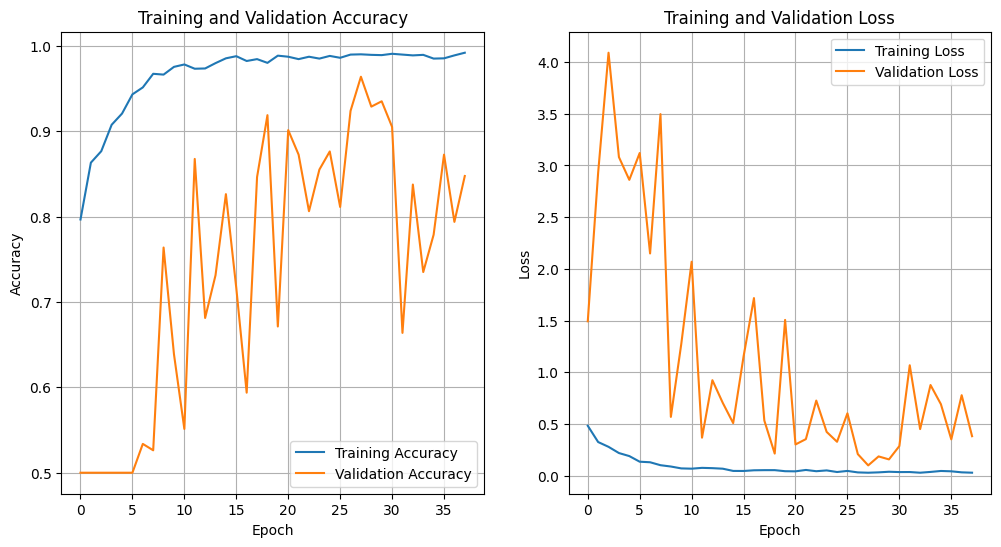


학습 결과 시각화 완료.


In [10]:
# 모델 복잡도 추가 조
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

# 이전에 정의된 IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE는 이전 코드 셀에서 사용되었으므로,
# 현재 셀에서 사용하려면 다시 정의하거나, 이전 셀이 실행되어 변수들이 전역적으로 사용 가능해야 합니다.
# 안전을 위해 여기서 다시 정의합니다.
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 32

# --- 1. 모델 구축 ---
# 간단한 CNN 모델 정의
def create_cnn_model(input_shape):
    model = models.Sequential([
        # 첫 번째 합성곱 블록
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(), # 배치 정규화 추가
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3), # Dropout 비율 0.25 -> 0.3으로 증가

        # 두 번째 합성곱 블록
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(), # 배치 정규화 추가
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3), # Dropout 비율 0.25 -> 0.3으로 증가

        # 세 번째 합성곱 블록
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(), # 배치 정규화 추가
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3), # Dropout 비율 0.25 -> 0.3으로 증가

        # 특징 맵을 1차원 벡터로 평탄화 (완전 연결 층에 입력하기 위함)
        layers.Flatten(),

        # 완전 연결 층
        layers.Dense(256, activation='relu'), # 뉴런 256개
        layers.BatchNormalization(), # 배치 정규화 추가
        layers.Dropout(0.6), # Dropout 비율 0.5 -> 0.6으로 증가

        # 출력 층
        # 이진 분류 (눈 감김/떠짐)이므로 sigmoid 활성화 함수를 사용합니다.
        # 출력 뉴런은 1개입니다.
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# 모델 생성
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3) # 컬러 이미지이므로 채널이 3
model = create_cnn_model(input_shape)

# 모델 요약 출력 (층별 구조와 파라미터 수 확인)
model.summary()

# 모델 컴파일
# optimizer: Adam은 일반적으로 좋은 성능을 보이는 최적화 알고리즘입니다.
# loss: 이진 분류이므로 binary_crossentropy를 사용합니다.
# metrics: 학습 및 평가 시 모니터링할 지표 (여기서는 정확도)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- 2. 모델 학습 ---
# 콜백 함수 설정 (모델 학습을 효율적으로 제어)
# EarlyStopping: 검증 손실이 개선되지 않으면 학습을 조기 종료하여 과적합 방지
# patience: 몇 epoch 동안 개선이 없으면 조기 종료할지 지정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ModelCheckpoint: 검증 정확도가 가장 높은 모델을 저장
# save_best_only=True: 가장 좋은 성능을 보이는 모델만 저장
model_checkpoint = ModelCheckpoint(
    'best_drowsiness_model.h5', # 저장될 모델 파일 이름
    monitor='val_accuracy',
    mode='max', # val_accuracy는 높을수록 좋으므로 'max'
    save_best_only=True,
    verbose=1 # 저장 시 메시지 출력
)

# 모델 학습
# epochs: 전체 훈련 데이터를 몇 번 반복하여 학습할지
# validation_data: 학습 중 모델 성능을 검증할 데이터셋
# callbacks: 위에 정의한 콜백 함수들
print("\n모델 학습 시작...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, # 한 epoch당 steps 수
    epochs=50, # 충분히 많은 epoch를 설정하고 EarlyStopping으로 조기 종료 유도
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE, # 한 epoch당 검증 steps 수
    callbacks=[early_stopping, model_checkpoint]
)

print("\n모델 학습 완료.")

# --- 3. 학습 결과 시각화 ---
# 학습 과정의 정확도와 손실 그래프
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.show()

print("\n학습 결과 시각화 완료.")


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,593 (9.24 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 2,258,240 (8.61 MB)


모델 학습 시작...
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9160 - loss: 0.2313
Epoch 1: val_accuracy improved from -inf to 0.90500, saving model to best_drowsiness_model_transfer.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 268ms/step - accuracy: 0.9164 - loss: 0.2301 - val_accuracy: 0.9050 - val_loss: 0.2387
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9829 - loss: 0.0525
Epoch 2: val_accuracy improved from 0.90500 to 0.95125, saving model to best_drowsiness_model_transfer.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.9828 - loss: 0.0524 - val_accuracy: 0.9513 - val_loss: 0.1553
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9871 - loss: 0.0434
Epoch 3: val_accuracy did not improve from 0.95125
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.9871 - loss: 0.0434 - val_accuracy: 0.8550 - val_loss: 0.3445
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9941 - loss: 0.0251
Epoch 4: val_accuracy did not improve from 0.95125
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.9941 - loss: 0.0251 - val_accuracy: 0.9062 - val_loss: 0.2002
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9921 - loss: 0.0240
Epoch 5: val_accuracy did not improve from 0.95125
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.9921 - loss: 0.0240 - val_accuracy: 0.9162 - val_loss: 0.2325
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9946 - loss: 0.0280
Epoch 6: val_ac

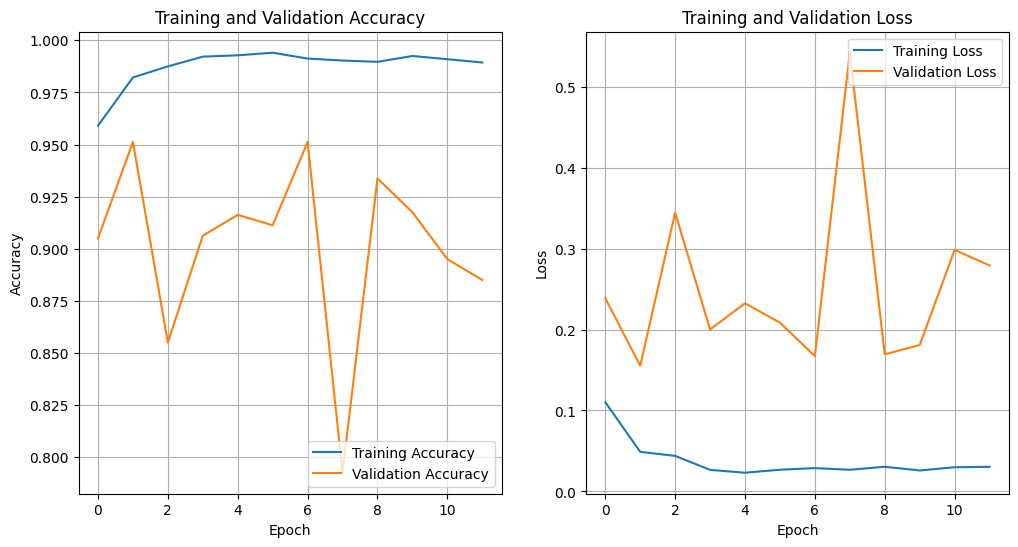


학습 결과 시각화 완료.


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

# 이전에 정의된 IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE는 이전 코드 셀에서 사용되었으므로,
# 현재 셀에서 사용하려면 다시 정의하거나, 이전 셀이 실행되어 변수들이 전역적으로 사용 가능해야 합니다.
# 안전을 위해 여기서 다시 정의합니다.
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 32

# --- 1. 모델 구축 (전이 학습 적용) ---
# 사전 학습된 MobileNetV2 모델을 로드하여 전이 학습을 적용합니다.
# include_top=False: 분류 층(fully connected layers)은 제외하고 특징 추출 부분만 가져옵니다.
# weights='imagenet': ImageNet 데이터셋으로 사전 학습된 가중치를 사용합니다.
# input_shape: 모델에 입력될 이미지의 크기를 정의합니다.
base_model = applications.MobileNetV2(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    include_top=False,
    weights='imagenet'
)

# 베이스 모델의 층들을 동결(freeze)하여 학습되지 않도록 합니다.
# 이미 ImageNet 데이터셋으로 강력한 특징을 학습했으므로, 이 부분을 고정하여
# 우리의 작은 데이터셋에서 과적합되는 것을 방지합니다.
base_model.trainable = False

# 새로운 분류 층(classification head)을 베이스 모델 위에 추가합니다.
def create_transfer_learning_model(base_model, input_shape):
    model = models.Sequential([
        base_model, # 사전 학습된 MobileNetV2 모델
        layers.GlobalAveragePooling2D(), # 특징 맵의 공간 차원을 줄입니다.
        layers.Dense(128, activation='relu'), # 새로운 완전 연결 층 (뉴런 128개)
        layers.BatchNormalization(), # 학습 안정화를 위한 배치 정규화
        layers.Dropout(0.5), # 과적합 방지를 위한 드롭아웃
        layers.Dense(1, activation='sigmoid') # 이진 분류를 위한 출력 층
    ])
    return model

# 전이 학습 모델 생성
model = create_transfer_learning_model(base_model, input_shape)

# 모델 요약 출력 (층별 구조와 파라미터 수 확인)
model.summary()

# 모델 컴파일
# optimizer: Adam은 일반적으로 좋은 성능을 보이는 최적화 알고리즘입니다.
# loss: 이진 분류이므로 binary_crossentropy를 사용합니다.
# metrics: 학습 및 평가 시 모니터링할 지표 (여기서는 정확도)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- 2. 모델 학습 ---
# 콜백 함수 설정 (모델 학습을 효율적으로 제어)
# EarlyStopping: 검증 손실이 개선되지 않으면 학습을 조기 종료하여 과적합 방지
# patience: 몇 epoch 동안 개선이 없으면 조기 종료할지 지정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ModelCheckpoint: 검증 정확도가 가장 높은 모델을 저장
# save_best_only=True: 가장 좋은 성능을 보이는 모델만 저장
model_checkpoint = ModelCheckpoint(
    'best_drowsiness_model_transfer.h5', # 저장될 모델 파일 이름 변경
    monitor='val_accuracy',
    mode='max', # val_accuracy는 높을수록 좋으므로 'max'
    save_best_only=True,
    verbose=1 # 저장 시 메시지 출력
)

# 모델 학습
# epochs: 전체 훈련 데이터를 몇 번 반복하여 학습할지
# validation_data: 학습 중 모델 성능을 검증할 데이터셋
# callbacks: 위에 정의한 콜백 함수들
print("\n모델 학습 시작...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, # 한 epoch당 steps 수
    epochs=50, # 충분히 많은 epoch를 설정하고 EarlyStopping으로 조기 종료 유도
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE, # 한 epoch당 검증 steps 수
    callbacks=[early_stopping, model_checkpoint]
)

print("\n모델 학습 완료.")

# --- 3. 학습 결과 시각화 ---
# 학습 과정의 정확도와 손실 그래프
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.show()

print("\n학습 결과 시각화 완료.")


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# eye_detection_model 객체가 메모리에 로드된 후에 실행해야 합니다.
model.save('/content/drive/MyDrive/best_drowsiness_model_transfer.h5')
print("눈 감지 모델이 Google Drive에 저장되었습니다.")

눈 감지 모델이 Google Drive에 저장되었습니다.


In [29]:
EYE_MODEL_PATH = '/content/drive/MyDrive/best_drowsiness_model_transfer.h5' # Google Drive 경로로 수정
YAWN_MODEL_PATH = '/content/drive/MyDrive/best_yawn_model_finetuned.h5'   # Google Drive 경로로 수정

In [30]:
import cv2
import dlib
import numpy as np
import imutils
from imutils import face_utils
from tensorflow.keras.models import load_model
import os
import time # 시간 측정을 위한 모듈

# --- 0. Dlib 얼굴 특징점 예측 모델 다운로드 ---
# 모델 파일 경로 설정
predictor_path = "shape_predictor_68_face_landmarks.dat"

# 파일이 없으면 다운로드 (Colab 환경에서)
if not os.path.exists(predictor_path):
    print("Dlib 얼굴 특징점 예측 모델 다운로드 중...")
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
    print("Dlib 모델 다운로드 및 압축 해제 완료.")
else:
    print("Dlib 모델이 이미 존재합니다.")

# --- 1. 학습된 모델 로드 ---
# 모델 파일 경로 설정 (기본은 /content/, Google Drive 사용 시 변경)
# Google Drive에 모델을 저장했다면, 아래 경로를 Google Drive 경로로 수정하세요.
# 예: /content/drive/MyDrive/best_drowsiness_model_transfer.h5
EYE_MODEL_PATH = 'best_drowsiness_model_transfer.h5' # 이 부분을 Google Drive 경로로 수정하세요!
YAWN_MODEL_PATH = 'best_yawn_model_finetuned.h5'   # 이 부분을 Google Drive 경로로 수정하세요!

# Google Drive 마운트 확인 및 안내 (코드가 실행될 때 경로 오류를 미리 알려줍니다)
if not os.path.exists(EYE_MODEL_PATH) or not os.path.exists(YAWN_MODEL_PATH):
    print("\n경고: 모델 파일을 지정된 경로에서 찾을 수 없습니다.")
    print("EYE_MODEL_PATH와 YAWN_MODEL_PATH 변수에 Google Drive에 저장된")
    print("모델 파일의 정확한 경로를 입력했는지 확인하세요.")
    print("예: EYE_MODEL_PATH = '/content/drive/MyDrive/your_drowsiness_model.h5'")
    print("    YAWN_MODEL_PATH = '/content/drive/MyDrive/your_yawn_model.h5'")
    print("\n만약 Google Drive에 저장하지 않았다면, 이전 학습 코드를 다시 실행하여 모델 파일을 생성해야 합니다.")
    # 실제 프로그램 종료를 위해 exit()를 사용할 수 있지만, Colab에서 디버깅 용이성을 위해 주석 처리합니다.
    # exit() # 모델 로드 실패 시 프로그램 종료

print("\n학습된 눈 감지 모델 로드 중...")
try:
    eye_detection_model = load_model(EYE_MODEL_PATH)
    print("눈 감지 모델 로드 완료.")
except Exception as e:
    print(f"눈 감지 모델 로드 실패: {e}")
    print(f"'{EYE_MODEL_PATH}' 경로의 모델 파일이 올바른지 확인하거나, 이전 학습 코드를 다시 실행하세요.")
    exit() # 모델 로드 실패 시 프로그램 종료

print("\n학습된 하품 감지 모델 로드 중...")
try:
    yawn_detection_model = load_model(YAWN_MODEL_PATH)
    print("하품 감지 모델 로드 완료.")
except Exception as e:
    print(f"하품 감지 모델 로드 실패: {e}")
    print(f"'{YAWN_MODEL_PATH}' 경로의 모델 파일이 올바른지 확인하거나, 이전 학습 코드를 다시 실행하세요.")
    exit() # 모델 로드 실패 시 프로그램 종료

# --- 2. Dlib 얼굴 검출기 및 특징점 예측기 초기화 ---
print("\nDlib 검출기 및 예측기 초기화 중...")
detector = dlib.get_frontal_face_detector() # 얼굴 검출기
predictor = dlib.shape_predictor(predictor_path) # 특징점 예측기
print("Dlib 초기화 완료.")

# --- 3. 눈과 입 특징점 인덱스 정의 ---
# Dlib 68점 특징점 인덱스에서 눈과 입 부분 추출
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_68_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_68_IDXS["right_eye"]
(mStart, mEnd) = face_utils.FACIAL_LANDMARKS_68_IDXS["mouth"]

# --- 4. 졸음 감지 파라미터 설정 ---
EYE_CLOSED_THRESHOLD = 0.5 # 눈 감김 모델 예측 확률 임계값 (0.5 이상이면 감김)
YAWN_THRESHOLD = 0.5       # 하품 모델 예측 확률 임계값 (0.5 이상이면 하품)

EYE_CLOSED_FRAMES_CONSEC = 20 # 눈이 연속적으로 감겨야 졸음으로 판단하는 프레임 수 (약 0.6초 ~ 1초)
YAWN_COUNT_THRESHOLD = 3   # 일정 시간 내 하품 횟수
YAWN_INTERVAL_SECONDS = 60 # 하품 횟수를 카운트할 시간 (초)

# 상태 변수 초기화
eye_closed_counter = 0 # 눈 감김 연속 프레임 카운터
yawn_timestamps = []   # 하품 발생 시간 기록

DROWSY_STATUS = "정상"
ALERT_MESSAGE = ""

# --- 5. 비디오 처리 함수 정의 ---
def process_frame(frame, visualize=True):
    global eye_closed_counter, yawn_timestamps, DROWSY_STATUS, ALERT_MESSAGE

    # 프레임을 흑백으로 변환 (dlib는 흑백 이미지에서 더 잘 작동)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 얼굴 검출
    rects = detector(gray, 0) # 0은 이미지 오버샘플링 횟수

    # 초기화 (매 프레임마다 상태를 초기화하고 다시 판단)
    current_eye_status = "눈_뜸"
    current_yawn_status = "하품_아님"
    # ALERT_MESSAGE는 특정 상태가 유지될 때만 변경되도록 여기서는 초기화하지 않습니다.

    if not rects: # 얼굴이 감지되지 않으면 카운터 초기화
        eye_closed_counter = 0
        DROWSY_STATUS = "정상"
        ALERT_MESSAGE = "" # 얼굴이 없으면 경고 초기화
        return frame # 얼굴이 없으면 더 이상 처리하지 않고 프레임 반환

    for rect in rects:
        # 얼굴 특징점 추출
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # 눈 영역 추출 및 분류
        left_eye = shape[lStart:lEnd]
        right_eye = shape[rStart:rEnd]

        # 눈 영역의 좌표를 이용하여 이미지에서 눈 부분만 잘라냅니다.
        # min/max를 사용하여 눈 영역의 경계 박스를 찾고, 넉넉한 크기로 잘라냅니다.
        (x_le, y_le, w_le, h_le) = cv2.boundingRect(left_eye)
        (x_re, y_re, w_re, h_re) = cv2.boundingRect(right_eye)

        # 눈 이미지를 잘라내고 모델 입력 크기로 조정
        # 너무 작은 영역이 잘리면 오류가 나므로 최소 크기 확인
        if h_le <= 0 or w_le <= 0 or h_re <= 0 or w_re <= 0:
            continue # 유효하지 않은 눈 영역이면 건너뜜

        left_eye_img = gray[y_le:y_le + h_le, x_le:x_le + w_le]
        right_eye_img = gray[y_re:y_re + h_re, x_re:x_re + w_re]

        # 눈 이미지가 유효한지 확인
        if left_eye_img.shape[0] == 0 or left_eye_img.shape[1] == 0 or \
           right_eye_img.shape[0] == 0 or right_eye_img.shape[1] == 0:
            continue # 유효하지 않은 눈 이미지면 건너뜾

        left_eye_img = cv2.resize(left_eye_img, (128, 128))
        right_eye_img = cv2.resize(right_eye_img, (128, 128))

        # 두 눈 이미지를 합쳐 모델 입력으로 준비 (흑백 -> 3채널로 복사)
        # MobileNetV2는 3채널 입력을 기대하므로, 흑백을 3채널로 복사합니다.
        combined_eye_img = np.concatenate((left_eye_img, right_eye_img), axis=1) # 가로로 합치기
        combined_eye_img = cv2.resize(combined_eye_img, (128, 128)) # 모델 입력 크기에 맞춤
        combined_eye_img = np.stack([combined_eye_img, combined_eye_img, combined_eye_img], axis=-1) # 1채널 -> 3채널
        combined_eye_img = np.expand_dims(combined_eye_img, axis=0) # 배치 차원 추가
        combined_eye_img = combined_eye_img / 255.0 # 정규화

        # 눈 감지 모델 예측
        eye_prediction = eye_detection_model.predict(combined_eye_img, verbose=0)[0][0]

        # 'Closed_Eyes' (0), 'Open_Eyes' (1) 인덱스에 따라 상태 업데이트
        # eye_detection_model의 클래스 인덱스는 {'Closed_Eyes': 0, 'Open_Eyes': 1} 입니다.
        # sigmoid 출력값이 0.5보다 작으면 0 (Closed_Eyes)으로 판단합니다.
        if eye_prediction < EYE_CLOSED_THRESHOLD: # 예측값이 0.5보다 작으면 Closed_Eyes (0)
            current_eye_status = "눈_감음"
            eye_closed_counter += 1
            if eye_closed_counter >= EYE_CLOSED_FRAMES_CONSEC:
                DROWSY_STATUS = "졸음_감지 (눈)"
                ALERT_MESSAGE = "눈 감김! 주의하세요!"
        else:
            current_eye_status = "눈_뜸"
            eye_closed_counter = 0 # 눈을 뜨면 카운터 초기화


        # 입 영역 추출 및 분류
        mouth = shape[mStart:mEnd]
        (x_m, y_m, w_m, h_m) = cv2.boundingRect(mouth)
        mouth_img = gray[y_m:y_m + h_m, x_m:x_m + w_m]

        if h_m <= 0 or w_m <= 0: # 유효하지 않은 입 영역이면 건너뜀
            continue

        if mouth_img.shape[0] == 0 or mouth_img.shape[1] == 0:
            continue # 유효하지 않은 입 이미지면 건너뜾

        mouth_img = cv2.resize(mouth_img, (128, 128))
        mouth_img = np.stack([mouth_img, mouth_img, mouth_img], axis=-1) # 1채널 -> 3채널
        mouth_img = np.expand_dims(mouth_img, axis=0) # 배치 차원 추가
        mouth_img = mouth_img / 255.0 # 정규화

        # 하품 감지 모델 예측
        # 하품 모델의 클래스 인덱스는 {'yawn': 0, 'no yawn': 1} 입니다.
        # sigmoid 출력값이 0.5보다 작으면 0 (yawn)으로 판단합니다.
        yawn_prediction = yawn_detection_model.predict(mouth_img, verbose=0)[0][0]

        if yawn_prediction < YAWN_THRESHOLD: # 예측값이 0.5보다 작으면 'yawn' (0)
            current_yawn_status = "하품_감지"
            # 현재 시간 기록 (초 단위)
            current_time = time.time()
            # YAWN_INTERVAL_SECONDS 이내의 하품만 유지
            yawn_timestamps = [ts for ts in yawn_timestamps if current_time - ts < YAWN_INTERVAL_SECONDS]
            # 최근 하품이 아니라면 추가 (중복 카운트 방지)
            if not yawn_timestamps or (current_time - yawn_timestamps[-1] > 1): # 1초 이내 중복 하품 방지
                 yawn_timestamps.append(current_time)

            if len(yawn_timestamps) >= YAWN_COUNT_THRESHOLD:
                DROWSY_STATUS = "졸음_감지 (하품)"
                ALERT_MESSAGE = "잦은 하품! 졸음운전 위험!"
        else:
            current_yawn_status = "하품_아님"


        # 시각화 (얼굴 특징점, 눈/입 영역 표시)
        if visualize:
            # 얼굴 경계 박스
            (x, y, w, h) = face_utils.rect_to_boundingbox(rect)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # 눈 특징점
            for (px, py) in left_eye:
                cv2.circle(frame, (px, py), 1, (0, 0, 255), -1)
            for (px, py) in right_eye:
                cv2.circle(frame, (px, py), 1, (0, 0, 255), -1)
            # 입 특징점
            for (px, py) in mouth:
                cv2.circle(frame, (px, py), 1, (255, 0, 0), -1)

            # 눈/하품 상태 텍스트
            cv2.putText(frame, f"Eye: {current_eye_status} ({eye_prediction:.2f})", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f"Yawn: {current_yawn_status} ({yawn_prediction:.2f})", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f"Drowsy: {DROWSY_STATUS}", (10, 90),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(frame, ALERT_MESSAGE, (10, 120),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    return frame

# --- 6. 비디오 파일 처리 예시 ---
# Colab에 비디오 파일 업로드 후 사용
# 예: files.upload()를 통해 'drive_video.mp4' 업로드
# 또는 Google Drive 마운트 후 경로 지정: /content/drive/MyDrive/drive_video.mp4

# 비디오 파일 경로 설정 (사용자가 직접 업로드하거나 Google Drive에서 가져와야 함)
video_path = 'drive_video.mp4' # 여기에 테스트할 비디오 파일 이름을 입력하세요.

# 비디오 파일이 없으면 안내 메시지 출력
if not os.path.exists(video_path):
    print(f"\n경고: 비디오 파일 '{video_path}'를 찾을 수 없습니다.")
    print("테스트를 위해 비디오 파일을 업로드하거나, 아래 정적 이미지 처리 예시를 활성화하세요.")
    print("예: Colab 좌측 파일 아이콘 -> 파일 업로드 -> drive_video.mp4 (또는 다른 비디오 파일) 업로드")
    print("   Google Drive에 있다면: video_path = '/content/drive/MyDrive/your_video.mp4'")
    # exit() # 비디오 파일 없으면 종료 (선택 사항)
else:
    cap = cv2.VideoCapture(video_path)

    # 비디오 속성 가져오기 (FPS, 프레임 너비/높이)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"\n비디오 파일 '{video_path}' 처리 시작...")
    print(f"FPS: {fps}, Width: {width}, Height: {height}, Total Frames: {total_frames}")

    # 비디오 출력 저장을 위한 VideoWriter 객체 생성 (선택 사항)
    output_video_path = 'output_drowsiness_detection.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # 코덱 설정
    # out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    # print(f"처리된 비디오는 '{output_video_path}'로 저장됩니다.")

    frame_count = 0
    start_time = time.time()

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            processed_frame = process_frame(frame.copy(), visualize=True)

            # 처리된 프레임을 화면에 표시 (Colab에서는 직접적인 cv2.imshow는 작동하지 않음)
            # Colab에서 실시간 미리보기는 복잡하며, 보통 이미지 저장 후 갤러리로 확인합니다.
            # 여기서는 프레임을 저장하거나 웹에 표시하는 대안을 고려해야 합니다.

            # 프레임 이미지로 저장 (테스트용)
            # 1초에 1프레임만 저장 (FPS를 고려하여 조절)
            # if frame_count % fps == 0:
            #     cv2.imwrite(f'/content/processed_frame_{frame_count:05d}.jpg', processed_frame)

            # 비디오 파일로 저장 (활성화 시)
            # if 'out' in locals() and out.isOpened():
            #     out.write(processed_frame)

            frame_count += 1
            if frame_count % (fps * 5) == 0: # 5초마다 진행 상황 출력
                elapsed_time = time.time() - start_time
                print(f"처리 중... {frame_count}/{total_frames} 프레임 ({elapsed_time:.2f}초 경과)")

    except Exception as e:
        print(f"비디오 처리 중 오류 발생: {e}")
    finally:
        cap.release()
        # 비디오 저장기가 활성화되어 있다면 해제
        # if 'out' in locals() and out.isOpened():
        #     out.release()
        print("\n비디오 처리 완료.")
        # if 'out' in locals() and out.isOpened():
        #     print(f"처리된 비디오는 '{output_video_path}'에 저장되었습니다. 다운로드하여 확인하세요.")
        print("\n경고: Colab 환경에서는 cv2.imshow가 직접 작동하지 않습니다. 결과를 시각적으로 확인하려면")
        print("      코드 내 주석 처리된 `cv2.imwrite` 또는 `cv2.VideoWriter` 부분을 활성화하여")
        print("      처리된 프레임을 이미지 파일로 저장하거나, 비디오로 저장하여 다운로드해야 합니다.")
        print(f"최종 졸음 상태: {DROWSY_STATUS}")
        print(f"최종 경고 메시지: {ALERT_MESSAGE}")


# --- 7. 정적 이미지 처리 예시 (선택 사항: 비디오 파일이 없을 때) ---
from google.colab.patches import cv2_imshow # Colab에서 이미지 표시를 위함

if not os.path.exists(video_path): # 비디오 파일이 없을 때만 실행
    print("\n--- 정적 이미지 처리 예시 ---")
    print("테스트할 이미지 파일을 업로드해주세요. (예: closed_eye.jpg, yawn_face.jpg)")
    # files.upload() # 이미지 파일 업로드 창 활성화 (필요시 주석 해제)
   # 업로드된 이미지 파일 경로 (실제 파일 이름으로 변경해야 함)
    image_path_closed = 'closed_eye.jpg' # 눈 감은 이미지 파일 이름
    image_path_yawn = 'yawn_face.jpg'     # 하품하는 이미지 파일 이름
    image_path_open = 'open_eye.jpg'      # 눈 뜬 이미지 파일 이름
    test_image_paths = [image_path_closed, image_path_yawn, image_path_open]
    for img_path in test_image_paths:
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                print(f"\n'{img_path}' 처리 결과:")
                processed_img = process_frame(img.copy(), visualize=True)
                cv2_imshow(processed_img) # Colab에서 이미지 표시
            else:
                print(f"오류: '{img_path}' 이미지를 로드할 수 없습니다.")
        else:
            print(f"경고: 테스트 이미지 '{img_path}'를 찾을 수 없습니다. 업로드하거나 경로를 확인하세요.")


Dlib 얼굴 특징점 예측 모델 다운로드 중...
--2025-06-07 19:30:13--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-06-07 19:30:13--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  33.6MB/s    in 1.8s    

2025-06-07 19:30:15 (33.6 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Dlib 모델 다운로드 및 압축 해제 완료.

경고: 모델 파일을 지정된 경로에서 찾을 수 없습니다.
EYE_MODEL_PATH와 YAWN_MODEL_PATH 변수에 Google Drive에 저장된
모델 파일의 정확한 경로를 입력했는지 확인하세요.
예: EYE_MODEL_

눈 감지 모델 로드 완료.

학습된 하품 감지 모델 로드 중...
하품 감지 모델 로드 실패: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_yawn_model_finetuned.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
'best_yawn_model_finetuned.h5' 경로의 모델 파일이 올바른지 확인하거나, 이전 학습 코드를 다시 실행하세요.

Dlib 검출기 및 예측기 초기화 중...
Dlib 초기화 완료.

경고: 비디오 파일 'drive_video.mp4'를 찾을 수 없습니다.
테스트를 위해 비디오 파일을 업로드하거나, 아래 정적 이미지 처리 예시를 활성화하세요.
예: Colab 좌측 파일 아이콘 -> 파일 업로드 -> drive_video.mp4 (또는 다른 비디오 파일) 업로드
   Google Drive에 있다면: video_path = '/content/drive/MyDrive/your_video.mp4'

--- 정적 이미지 처리 예시 ---
테스트할 이미지 파일을 업로드해주세요. (예: closed_eye.jpg, yawn_face.jpg)
경고: 테스트 이미지 'closed_eye.jpg'를 찾을 수 없습니다. 업로드하거나 경로를 확인하세요.
경고: 테스트 이미지 'yawn_face.jpg'를 찾을 수 없습니다. 업로드하거나 경로를 확인하세요.
경고: 테스트 이미지 'open_eye.jpg'를 찾을 수 없습니다. 업로드하거나 경로를 확인하세요.
